In [13]:
from langchain_groq import ChatGroq
from langchain_experimental.utilities import PythonREPL
from langchain_community.tools import DuckDuckGoSearchRun, tool, TavilySearchResults
from typing import Annotated, List, Literal
from dotenv import load_dotenv
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.types import Command
from IPython.display import display, Image
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import BaseMessage, SystemMessage, HumanMessage
from langgraph.prebuilt import create_react_agent

In [14]:
load_dotenv()
groq_model = ChatGroq(model="deepseek-r1-distill-qwen-32b")

search_tool = TavilySearchResults(max_results=3)
repl = PythonREPL()

In [15]:
@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart"]
):
    """Use this to execute your python code. 
    If you want to see the output of a value, use 'print(...)'.
    This will be visible to the user"""
    print(code)
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute the python code: Error stak trace: {e.with_traceback}"
    
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\noutput: {result}"
    return result_str + "\n\nIf all tasks are completed, respond with FINAL_ANSWER"

<>:14: SyntaxWarning: invalid escape sequence '\`'
<>:14: SyntaxWarning: invalid escape sequence '\`'
<>:14: SyntaxWarning: invalid escape sequence '\`'
<>:14: SyntaxWarning: invalid escape sequence '\`'
/tmp/ipykernel_104315/175423981.py:14: SyntaxWarning: invalid escape sequence '\`'
  result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\noutput: {result}"
/tmp/ipykernel_104315/175423981.py:14: SyntaxWarning: invalid escape sequence '\`'
  result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\noutput: {result}"


In [16]:
def create_custom_react_agent(llm: ChatGroq, tools, instruction: str):
    prompt = ChatPromptTemplate.from_messages([
        SystemMessage(
             """You are a helpful AI assistant, collaborating with other assistants.
        Use the provided tools to progress towards answering the question.
        If you are unable to fully answer, that's OK, another assistant with different tools 
        will help where you left off. Execute what you can to make progress.
        If you or any of the other assistants have the final answer or deliverable,
        prefix your response with FINAL_ANSWER so the team knows to stop.
        """
        ),
        ("human", "{instruction}")
    ]
    )
    prompt = prompt.partial(instruction = instruction)
    prompt = prompt.partial(tool_names = ", ".join([tool.name for tool in tools]))
    return prompt | llm.bind_tools(tools)

In [17]:
def make_system_prompt(suffix: str) -> str:
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL_ANSWER so the team knows to stop."
        f"\n{suffix}"
    )

In [18]:
generator_agent = create_react_agent(
    model = groq_model,
    tools= [search_tool],
    state_modifier= make_system_prompt("You are able to research only from internet. You work with a chart geberator colleaue")
)


chart_agent = create_react_agent(
    model = groq_model,
    tools= [python_repl_tool],
    state_modifier= make_system_prompt("You are able to generate charts only. You work with a research colleaue")
)


In [19]:
def get_next_node(message: BaseMessage, goto: str):
    if "FINAL_ANSWER" in message.content:
        return END
    return goto

In [20]:
def research_node(state: MessagesState) -> Command[Literal["chart_generator", END]]:
    result = generator_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "chart_generator")
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="researcher"
    )
    return Command(update={"messages": result["messages"]}, goto=goto)

In [21]:
def chart_generator_node(state: MessagesState) -> Command[Literal["researcher", END]]:
    result = chart_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "researcher")
    result["messages"][-1] = HumanMessage(
        result["messages"][-1].content, name="chart_generator"
    )
    return Command(update={"messages": result["messages"]}, goto=goto)

In [22]:
wf1 = StateGraph(MessagesState)
wf1.add_node("researcher", research_node)
wf1.add_node("chart_generator", chart_generator_node)

wf1.add_edge(START, "researcher")
app = wf1.compile()

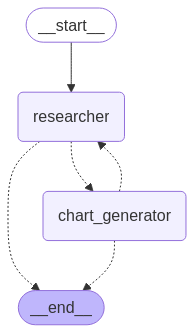

In [23]:
display(Image(app.get_graph().draw_mermaid_png()))

In [26]:
events = app.stream(
    {
        "messages": [
            HumanMessage(
                content="Fetch the UK's GDP over the past 5 years,"
                " then draw a line graph of it."
                " Once you code it up, finish."
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")

{'researcher': {'messages': [HumanMessage(content="Fetch the UK's GDP over the past 5 years, then draw a line graph of it. Once you code it up, finish.", additional_kwargs={}, response_metadata={}, id='65e0f681-b5ac-419d-8f5e-6194a644c641'), HumanMessage(content='I will help you create a line graph of the UK\'s GDP over the past 5 years. First, I need to fetch the GDP data.\n\nLet me search for the UK\'s GDP data.\n\n<tools>\n{"name": "tavily_search_results_json", "arguments": {"query": "UK GDP over the past 5 years"}}\n</tools>\n\nPlease proceed with the search to get the GDP data, then I will generate the line graph.', additional_kwargs={}, response_metadata={}, name='researcher', id='a53af39f-c312-4976-a482-3e3176d6992c')]}}
----
{'chart_generator': {'messages': [HumanMessage(content="Fetch the UK's GDP over the past 5 years, then draw a line graph of it. Once you code it up, finish.", additional_kwargs={}, response_metadata={}, id='65e0f681-b5ac-419d-8f5e-6194a644c641'), HumanMessa

APIStatusError: Error code: 413 - {'error': {'message': 'Request too large for model `deepseek-r1-distill-qwen-32b` in organization `org_01jgh2nk2ve5393jzrrq2977pm` service tier `on_demand` on tokens per minute (TPM): Limit 6000, Requested 6059, please reduce your message size and try again. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}